# Laboratorio 2 - Agrupación
Grupo 14

## Entendimiento de datos
Dentro de este laboratorio se hará uso de los datos pertenecientes al archivo `Datos_SenecaféAlpes.csv`. A continuación, se detalla el proceso de carga, entendimiento y calidad de datos.

In [1987]:
import os
import numpy as np
import pandas as pd
from sklearn import tree
import sklearn as sklearn
import matplotlib.cm as cm


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # for 3D plots
import seaborn as sns; sns.set()


from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler

# Modelos
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans, DBSCAN

# Métricas
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,
    silhouette_score, davies_bouldin_score, silhouette_samples
)
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.decomposition import PCA
import joblib

np.random.seed(42)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 50)


In [1988]:
#Carga de datos
df = pd.read_csv('Datos_SenecaféAlpes.csv', encoding="UTF-8", sep=";")
df.shape

(14291, 19)

Para entender el significado de cada una de las columnas se incluye el diccionario.

In [1989]:
diccionario = pd.read_excel('Diccionario_SenecaféAlpes.xlsx')
pd.set_option("display.max_colwidth", None)
display(diccionario)

,ATRIBUTO,DESCRIPCIÓN
0,ID,Código único generado para cada grano de café inspeccionado.
1,Área,"Superficie ocupada por el grano, medida como el número total de píxeles dentro de sus límites. Indica el tamaño del grano."
2,Perímetro,"Longitud de la frontera del grano, equivalente a su circunferencia. Refleja la complejidad y continuidad del borde."
3,LongitudEjeMayor,Distancia entre los extremos de la línea más larga que puede trazarse a lo largo del grano. Representa la longitud máxima del grano.
4,LongitudEjeMenor,Longitud de la línea más larga que puede trazarse perpendicular al eje mayor. Refleja el ancho máximo transversal del grano.
5,RelaciónAspecto,Relación entre la longitud del eje mayor y la del eje menor. Indica si el grano es Alargado (> 1.3) o Redondeado (≤ 1.3).
6,Excentricidad,"Medida de la desviación de la forma respecto a un círculo, basada en la elipse equivalente. Valores cercanos a 0 indican formas circulares; cercanos a 1, formas alargadas."
7,ÁreaConvexa,Número de píxeles contenidos en el polígono convexo más pequeño que abarca el grano. Permite identificar irregularidades en el borde.
8,DiámetroEquivalente,Diámetro de un círculo con el mismo área que el grano. Facilita la comparación entre granos de distintas formas mediante una medida circular equivalente.
9,Medida,Proporción entre el área del grano y el área de su caja delimitadora (bounding box). Evalúa qué tan bien el grano ocupa su espacio mínimo rectangular.


In [1990]:
df.head()

,ID,Area,Perimetro,LongitudEjeMayor,LongitudEjeMenor,RelacionAspecto,Excentricidad,AreaConvexa,DiametroEquivalente,Medida,Solidez,Redondez,Compacidad,FactorForma1,FactorForma2,FactorForma3,FactorForma4,DefectoVisible,MétodoSecado
0,G006149,50836,923618.0,358.515147,181.388899,alargado,NaN,NaN,254.413847,0.804762,0.983840,0.748853,0.709632,0.007052,0.001103,0.503578,0.995321,Normal,Lavado
1,G007234,62764,1003767.0,409.207082,198.330199,Alargado,NaN,64158.0,282.689948,0.703995,0.978272,0.782807,0.690824,0.006520,0.000916,0.477237,0.984666,NaN,Natural
2,G007054,59965,994266.0,389.088529,197.967275,Alargado,0.860886,60910.0,276.314692,0.661581,0.984485,0.762259,0.710159,0.006489,0.001018,0.504326,0.991211,Normal,Natural
3,G006619,55035,917.6,379.346822,185.390577,Alargado,0.872446,55591.0,NaN,0.799695,0.989998,0.821376,0.697811,0.006893,0.001008,0.486941,0.996380,Normal,Lavado
4,G013353,39324,737773.0,262.520242,191.176858,Alargado,0.685326,39758.0,223.760747,0.775392,0.989084,0.907867,0.852356,0.006676,0.002174,0.726511,0.997630,Normal,Lavado


In [1991]:
df.dtypes

ID                      object
Area                     int64
Perimetro              float64
LongitudEjeMayor       float64
LongitudEjeMenor       float64
RelacionAspecto         object
Excentricidad          float64
AreaConvexa            float64
DiametroEquivalente    float64
Medida                 float64
Solidez                float64
Redondez               float64
Compacidad             float64
FactorForma1           float64
FactorForma2           float64
FactorForma3           float64
FactorForma4           float64
DefectoVisible          object
MétodoSecado            object
dtype: object

In [1992]:
df.describe()

,Area,Perimetro,LongitudEjeMayor,LongitudEjeMenor,Excentricidad,AreaConvexa,DiametroEquivalente,Medida,Solidez,Redondez,Compacidad,FactorForma1,FactorForma2,FactorForma3,FactorForma4
count,14291.000000,1.305400e+04,13890.000000,14291.000000,13687.000000,12868.000000,12368.000000,14291.000000,11985.000000,12228.000000,13641.000000,13172.000000,13185.000000,13813.000000,13132.000000
mean,53055.408999,7.729870e+05,319.985592,202.178613,0.749977,53575.397809,253.001741,0.749844,0.986774,0.873080,0.799242,0.006560,0.001712,0.643183,0.994292
std,29396.080372,3.266493e+05,86.378452,45.494541,0.099438,29566.387814,60.542330,0.050774,0.025947,0.063237,0.067643,0.001164,0.000601,0.100857,0.039081
min,-62716.000000,-1.012143e+06,-421.444657,-200.838672,-0.835004,-78423.000000,-448.402605,-0.798706,-0.989042,-0.896861,-0.843901,-0.007982,-0.002673,-0.683269,-0.998527
25%,36338.000000,6.768608e+05,253.319858,175.881052,0.715144,36720.000000,215.302463,0.718767,0.985597,0.832824,0.762127,0.005903,0.001151,0.581047,0.993663
50%,44660.000000,7.720345e+05,296.682345,192.437870,0.764392,45107.500000,238.579492,0.760232,0.988279,0.883353,0.800994,0.006645,0.001691,0.641648,0.996377
75%,61311.000000,9.554098e+05,376.548109,216.847844,0.810441,62109.250000,279.672481,0.786942,0.989991,0.916803,0.834405,0.007273,0.002169,0.696366,0.997889
max,254616.000000,1.921685e+06,738.860154,460.198497,0.911423,251082.000000,569.374358,0.866195,0.994378,0.990685,0.987303,0.010451,0.003665,0.974767,0.999733


In [1993]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14291 entries, 0 to 14290
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   14291 non-null  object 
 1   Area                 14291 non-null  int64  
 2   Perimetro            13054 non-null  float64
 3   LongitudEjeMayor     13890 non-null  float64
 4   LongitudEjeMenor     14291 non-null  float64
 5   RelacionAspecto      13825 non-null  object 
 6   Excentricidad        13687 non-null  float64
 7   AreaConvexa          12868 non-null  float64
 8   DiametroEquivalente  12368 non-null  float64
 9   Medida               14291 non-null  float64
 10  Solidez              11985 non-null  float64
 11  Redondez             12228 non-null  float64
 12  Compacidad           13641 non-null  float64
 13  FactorForma1         13172 non-null  float64
 14  FactorForma2         13185 non-null  float64
 15  FactorForma3         13813 non-null 

A partir de los tipos de dato de cada columna, se identifica que existen 3 columnas categóricas: DefectoVisible, MétodoSecado y RelacionAspecto. Aparte de la columna ID la cual será ignorada. 



In [1994]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in df.columns if c not in numeric_cols]
print(numeric_cols)
print(categorical_cols)


['Area', 'Perimetro', 'LongitudEjeMayor', 'LongitudEjeMenor', 'Excentricidad', 'AreaConvexa', 'DiametroEquivalente', 'Medida', 'Solidez', 'Redondez', 'Compacidad', 'FactorForma1', 'FactorForma2', 'FactorForma3', 'FactorForma4']
['ID', 'RelacionAspecto', 'DefectoVisible', 'MétodoSecado']


## Histograma por atributo 
A continuación, se presenta un histograma por atributo. Con este se puede ver que los atributos `Solidez`, `FactorForma4`, `Redondez` y `Compacidad`tienen una distribución centrada en valores de 1 o muy cercanos. Otros atributos como `Area`, `LongitudEjeMenor`, `LongitudEjeMayor`, `AreaConvexa` y `DiametroEquivalente` tienen colas de datos a la derecha. Finalmente, el `Perimetro` tiene una distribución con unos datos hacía la derecha y datos muy cercanos a 0. Este comportamiento debe revisarse para identificar si se trata de outliers o si es una consecuencia de otros factores. 

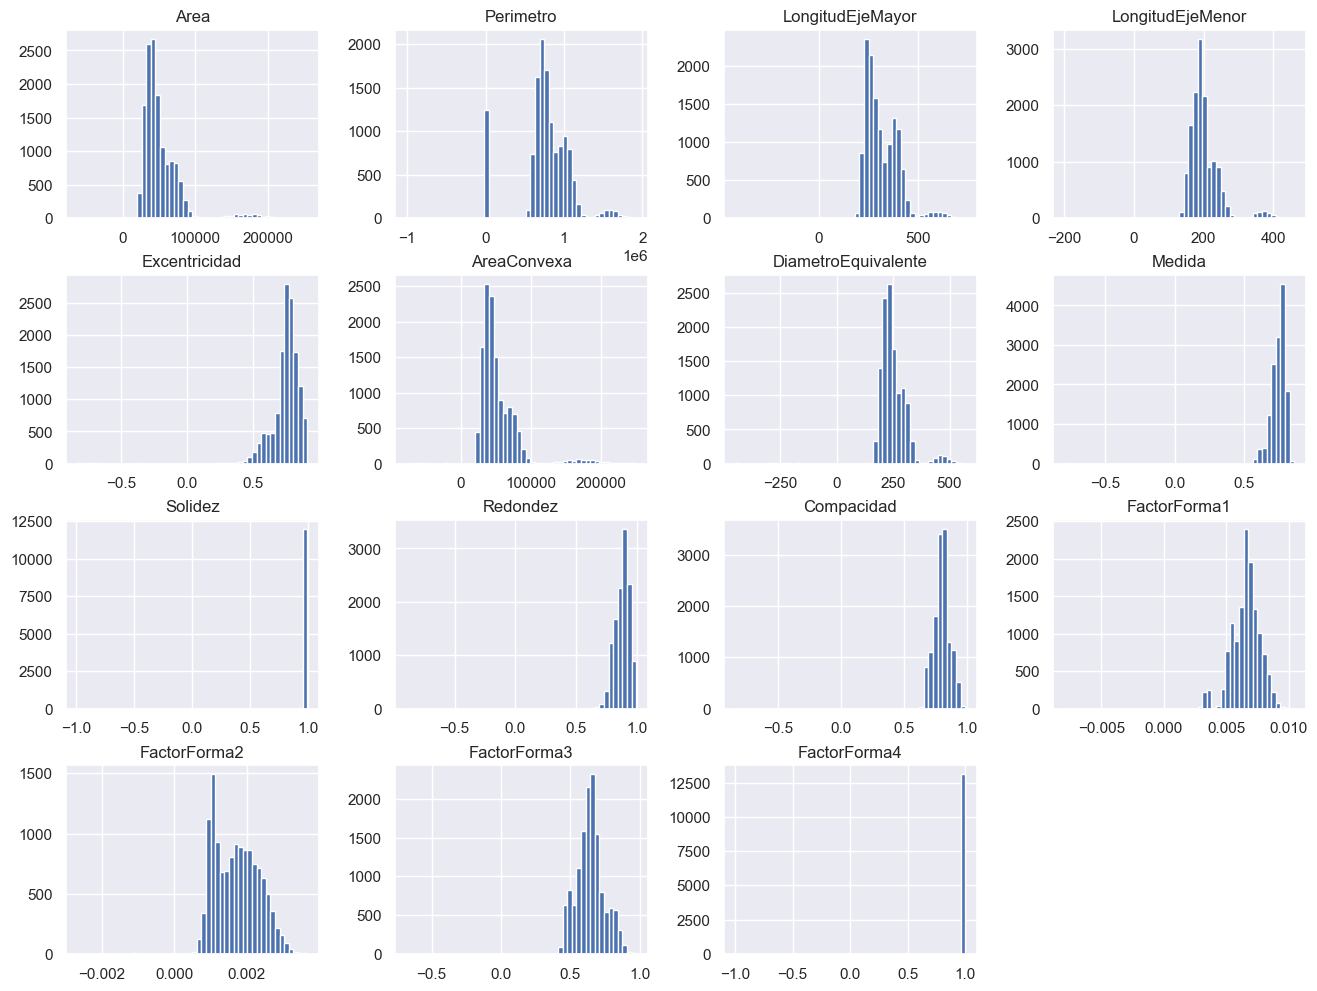

In [1995]:
df.hist(bins=50, figsize=(16, 12))
plt.show()

## Completitud

In [1996]:
print("Datos Nulos")
print(df.isnull().sum())

Datos Nulos
ID                        0
Area                      0
Perimetro              1237
LongitudEjeMayor        401
LongitudEjeMenor          0
RelacionAspecto         466
Excentricidad           604
AreaConvexa            1423
DiametroEquivalente    1923
Medida                    0
Solidez                2306
Redondez               2063
Compacidad              650
FactorForma1           1119
FactorForma2           1106
FactorForma3            478
FactorForma4           1159
DefectoVisible         2935
MétodoSecado            587
dtype: int64


In [1997]:
print("Proporción Datos Nulos")
print((df.isnull().sum()/len(df))*100 )

Proporción Datos Nulos
ID                      0.000000
Area                    0.000000
Perimetro               8.655797
LongitudEjeMayor        2.805962
LongitudEjeMenor        0.000000
RelacionAspecto         3.260794
Excentricidad           4.226436
AreaConvexa             9.957316
DiametroEquivalente    13.456021
Medida                  0.000000
Solidez                16.136030
Redondez               14.435659
Compacidad              4.548317
FactorForma1            7.830103
FactorForma2            7.739137
FactorForma3            3.344762
FactorForma4            8.109999
DefectoVisible         20.537401
MétodoSecado            4.107480
dtype: float64


Con el cálculos de valores nulos por columna, se puede ver que los atributos con mayor falta de información son: DefectoVisible, Solidez, Redondez, y DiametroEquivalente. En general, se deben considerar técnicas de imputación ya que hay muy pocos atributos que cuenten con una información totalmente completa.
Para los atributos numéricos se puede usar la media de los registros y para los categóricos se propone imputar haciendo uso de la moda.

Para el caso de DefectoVisible ya que el hay un 20.53% de datos vacíos, se completan los datos pero más adelante este detalle se tiene en cuenta debido a que se debe estudiar si este atributo es relevante para el problema o si llega a introducir sesgos. 


## Unicidad


In [1998]:
df.loc[df.duplicated(keep = "first")]

,ID,Area,Perimetro,LongitudEjeMayor,LongitudEjeMenor,RelacionAspecto,Excentricidad,AreaConvexa,DiametroEquivalente,Medida,Solidez,Redondez,Compacidad,FactorForma1,FactorForma2,FactorForma3,FactorForma4,DefectoVisible,MétodoSecado
384,G001698,44524,758387.0,258.916322,219.129976,Redondeado,NaN,44860.0,238.096026,0.782977,NaN,0.972797,0.919587,0.005815,0.002565,0.845640,0.999178,Normal,Lavado
507,G002702,69824,1055572.0,389.048708,229.112799,Alargado,0.808202,70943.0,298.165521,0.688396,0.984227,0.787479,0.766396,0.005572,0.001186,0.587363,0.997382,Normal,Natural
544,G003108,78848,1088405.0,388.645864,259.122237,Alargado,0.745298,79719.0,316.847584,0.734577,0.989074,0.836411,0.815260,0.004929,0.001343,0.664650,0.996878,Normal,Natural
569,G013443,40125,738378.0,275.637443,185.812657,Alargado,0.738622,40508.0,226.028177,0.774614,0.990545,0.924842,0.820020,0.006869,0.001916,0.672433,0.997497,Normal,Lavado
639,G002184,57995,NaN,324.569677,229.352384,Alargado,0.707578,NaN,271.737976,0.746003,0.982999,0.844240,0.837225,0.005597,0.001696,0.700946,0.991949,Normal,Natural
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14087,G007878,40462,751445.0,278.924258,185.017159,NaN,0.748332,40894.0,226.975370,0.785975,0.989436,0.900457,0.813753,0.006893,0.001865,0.662193,0.998296,Normal,NaN
14089,G003144,79874,1093895.0,382.913187,270.423338,Alargado,0.707986,81979.0,318.902392,0.760755,0.974323,0.838811,0.832832,0.004794,0.001423,0.693609,NaN,Normal,Lavado
14143,G012802,35995,NaN,257.442963,178.548674,Alargado,0.720412,36354.0,NaN,0.795470,0.990125,0.931469,0.831563,0.007152,0.002110,0.691497,0.997045,Normal,Lavado
14159,G001254,40705,738355.0,249.136239,208.625320,Redondeado,0.546599,41147.0,227.655915,0.764413,0.989258,NaN,0.913781,0.006121,0.002632,0.834995,0.997135,Normal,Lavado


In [1999]:
df = df.drop_duplicates()

In [2000]:
df.shape

(13830, 19)

Se detectaron 461 registros completamente duplicados, los cuales fueron eliminados. Esta decisión se tomó ya que se siguen teniendo 13830 registros, razón por la cual se sigue contando con información suficiente. 

Como se tiene la columna de ID del grano, se ignora este atributo y se revisan nuevamente duplicados. Esto con el fin de ver filtrar registrso que puedan presentar problemas para el dataset pese a no se duplicados completos. 


In [2001]:
df.loc[df.duplicated(subset=df.columns.difference(['ID']), keep=False)]

,ID,Area,Perimetro,LongitudEjeMayor,LongitudEjeMenor,RelacionAspecto,Excentricidad,AreaConvexa,DiametroEquivalente,Medida,Solidez,Redondez,Compacidad,FactorForma1,FactorForma2,FactorForma3,FactorForma4,DefectoVisible,MétodoSecado
2063,G005822,46863,867433.0,347.442755,172.128791,Alargado,0.868656,47538.0,244.269983,0.700703,0.985801,0.782651,0.703051,0.007414,0.001117,0.494281,0.997708,Normal,Natural
6343,G005821,46863,867433.0,347.442755,172.128791,Alargado,0.868656,47538.0,244.269983,0.700703,0.985801,0.782651,0.703051,0.007414,0.001117,0.494281,0.997708,Normal,Natural


In [2002]:
cols = numeric_cols + categorical_cols
df = df.drop_duplicates(subset=cols)
df.shape

(13830, 19)

Al revisar el caso de duplicados parciales evitando el ID, se encuentra que hay un caso adicional que se debe eliminar. 

Como se resolvió la unicidad, se resuelven los problemas de completitud. No se realizó previamente ya que como se va a realizar imputación con media y moda, estos valores estadísticos se pueden ver afectados por duplicados. 

In [2003]:
for col in numeric_cols:
  df[col] = df[col].fillna(df[col].mean())

for col in categorical_cols:
  df[col] = df[col].fillna(df[col].mode()[0])


In [2004]:
print("Proporción Datos Nulos")
print((df.isnull().sum()/len(df))*100 )

Proporción Datos Nulos
ID                     0.0
Area                   0.0
Perimetro              0.0
LongitudEjeMayor       0.0
LongitudEjeMenor       0.0
RelacionAspecto        0.0
Excentricidad          0.0
AreaConvexa            0.0
DiametroEquivalente    0.0
Medida                 0.0
Solidez                0.0
Redondez               0.0
Compacidad             0.0
FactorForma1           0.0
FactorForma2           0.0
FactorForma3           0.0
FactorForma4           0.0
DefectoVisible         0.0
MétodoSecado           0.0
dtype: float64


Al aplicar imputación de datos, se logra que estos estén completos y no se tengan valores faltantes.

## Consistencia

A continuación, se revisan los datos de cada columna categórica. Esto tiene como fin revisar que tipos de valores hay y tener una noción preliminar de si la codificación es consistente.

In [2005]:
df.value_counts("RelacionAspecto", dropna=False)

RelacionAspecto
Alargado      12113
Redondeado     1678
alargado         29
redondeado       10
Name: count, dtype: int64

In [2006]:
df.value_counts("DefectoVisible", dropna=False)

DefectoVisible
Normal    11581
normal     2249
Name: count, dtype: int64

In [2007]:
df.value_counts("MétodoSecado", dropna=False)

MétodoSecado
Lavado     6552
Natural    4495
lavado     1540
natural    1168
Honey        62
honey        13
Name: count, dtype: int64

Como se puede ver, todas las columnas categóricas tienen información con diferentes tipos de codificación. Es decir, hay diferencias en como se escriben los valores, lo que se debe arreglar para que se pueda manejar apropiadamente estos datos.

In [2008]:
df['RelacionAspecto'] = df['RelacionAspecto'].replace('alargado', 'Alargado')
df['RelacionAspecto'] = df['RelacionAspecto'].replace('redondeado', 'Redondeado')
df['DefectoVisible'] = df['DefectoVisible'].replace('normal', 'Normal')
df['MétodoSecado'] = df['MétodoSecado'].replace('lavado', 'Lavado')
df['MétodoSecado'] = df['MétodoSecado'].replace('natural', 'Natural')
df['MétodoSecado'] = df['MétodoSecado'].replace('honey', 'Honey')
df.head()


,ID,Area,Perimetro,LongitudEjeMayor,LongitudEjeMenor,RelacionAspecto,Excentricidad,AreaConvexa,DiametroEquivalente,Medida,Solidez,Redondez,Compacidad,FactorForma1,FactorForma2,FactorForma3,FactorForma4,DefectoVisible,MétodoSecado
0,G006149,50836,923618.0,358.515147,181.388899,Alargado,0.749921,53521.754117,254.413847,0.804762,0.983840,0.748853,0.709632,0.007052,0.001103,0.503578,0.995321,Normal,Lavado
1,G007234,62764,1003767.0,409.207082,198.330199,Alargado,0.749921,64158.000000,282.689948,0.703995,0.978272,0.782807,0.690824,0.006520,0.000916,0.477237,0.984666,Normal,Natural
2,G007054,59965,994266.0,389.088529,197.967275,Alargado,0.860886,60910.000000,276.314692,0.661581,0.984485,0.762259,0.710159,0.006489,0.001018,0.504326,0.991211,Normal,Natural
3,G006619,55035,917.6,379.346822,185.390577,Alargado,0.872446,55591.000000,252.859008,0.799695,0.989998,0.821376,0.697811,0.006893,0.001008,0.486941,0.996380,Normal,Lavado
4,G013353,39324,737773.0,262.520242,191.176858,Alargado,0.685326,39758.000000,223.760747,0.775392,0.989084,0.907867,0.852356,0.006676,0.002174,0.726511,0.997630,Normal,Lavado


## Validez

En cuanto a validez, se analiza que los datos tengan sentido dentro del contexto. Para esto, se tendrá especial atención en los datos numéricos. En cuanto a los atributos numéricos, partiendo de la definición del diccionario deberían tener valores positivos. 

In [2009]:
((df[numeric_cols] < 0).sum()/len(df))*100

Area                   0.021692
Perimetro              0.043384
LongitudEjeMayor       0.021692
LongitudEjeMenor       0.028923
Excentricidad          0.065076
AreaConvexa            0.043384
DiametroEquivalente    0.050615
Medida                 0.007231
Solidez                0.014461
Redondez               0.014461
Compacidad             0.028923
FactorForma1           0.043384
FactorForma2           0.050615
FactorForma3           0.021692
FactorForma4           0.036153
dtype: float64

Como el porcentaje de datos faltantes es muy bajo, se decide eliminar los registros que no son validos. 

In [2010]:
df_clean = df[(df[numeric_cols] >= 0).all(axis=1)]

Finalmente, se codifican las columnas con valores categóricos. Para esto se utiliza One Hot Encoding debido a que no son categorías que tengan orden y se elimina la columna ID ya que no aporta a como atributo al problema.  

In [2011]:
df_clean = pd.get_dummies(df_clean, columns=['MétodoSecado', 'DefectoVisible','RelacionAspecto']) 
df_clean = df_clean.drop('ID', axis=1)

In [2012]:
df_clean.head()

,Area,Perimetro,LongitudEjeMayor,LongitudEjeMenor,Excentricidad,AreaConvexa,DiametroEquivalente,Medida,Solidez,Redondez,Compacidad,FactorForma1,FactorForma2,FactorForma3,FactorForma4,MétodoSecado_Honey,MétodoSecado_Lavado,MétodoSecado_Natural,DefectoVisible_Normal,RelacionAspecto_Alargado,RelacionAspecto_Redondeado
0,50836,923618.0,358.515147,181.388899,0.749921,53521.754117,254.413847,0.804762,0.983840,0.748853,0.709632,0.007052,0.001103,0.503578,0.995321,False,True,False,True,True,False
1,62764,1003767.0,409.207082,198.330199,0.749921,64158.000000,282.689948,0.703995,0.978272,0.782807,0.690824,0.006520,0.000916,0.477237,0.984666,False,False,True,True,True,False
2,59965,994266.0,389.088529,197.967275,0.860886,60910.000000,276.314692,0.661581,0.984485,0.762259,0.710159,0.006489,0.001018,0.504326,0.991211,False,False,True,True,True,False
3,55035,917.6,379.346822,185.390577,0.872446,55591.000000,252.859008,0.799695,0.989998,0.821376,0.697811,0.006893,0.001008,0.486941,0.996380,False,True,False,True,True,False
4,39324,737773.0,262.520242,191.176858,0.685326,39758.000000,223.760747,0.775392,0.989084,0.907867,0.852356,0.006676,0.002174,0.726511,0.997630,False,True,False,True,True,False


Con la preparación de datos, se generan nuevas gráficas para analizar como están actualmente los datos.

### Histogramas de features

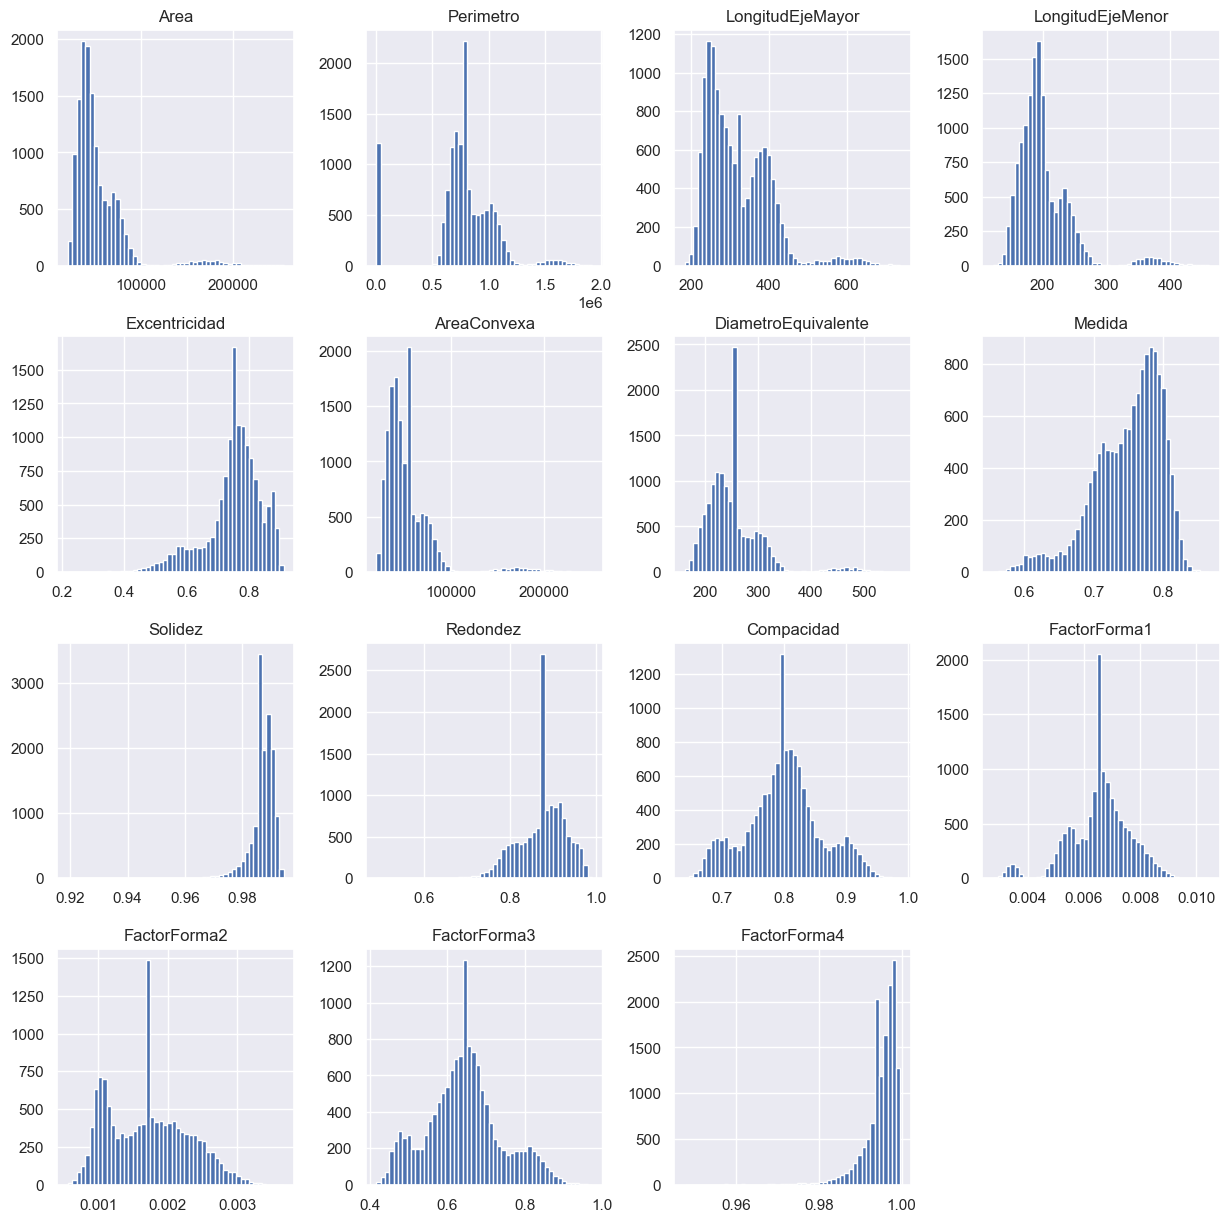

In [2013]:
df_clean.hist(bins=50, figsize=(15, 15))
plt.show()

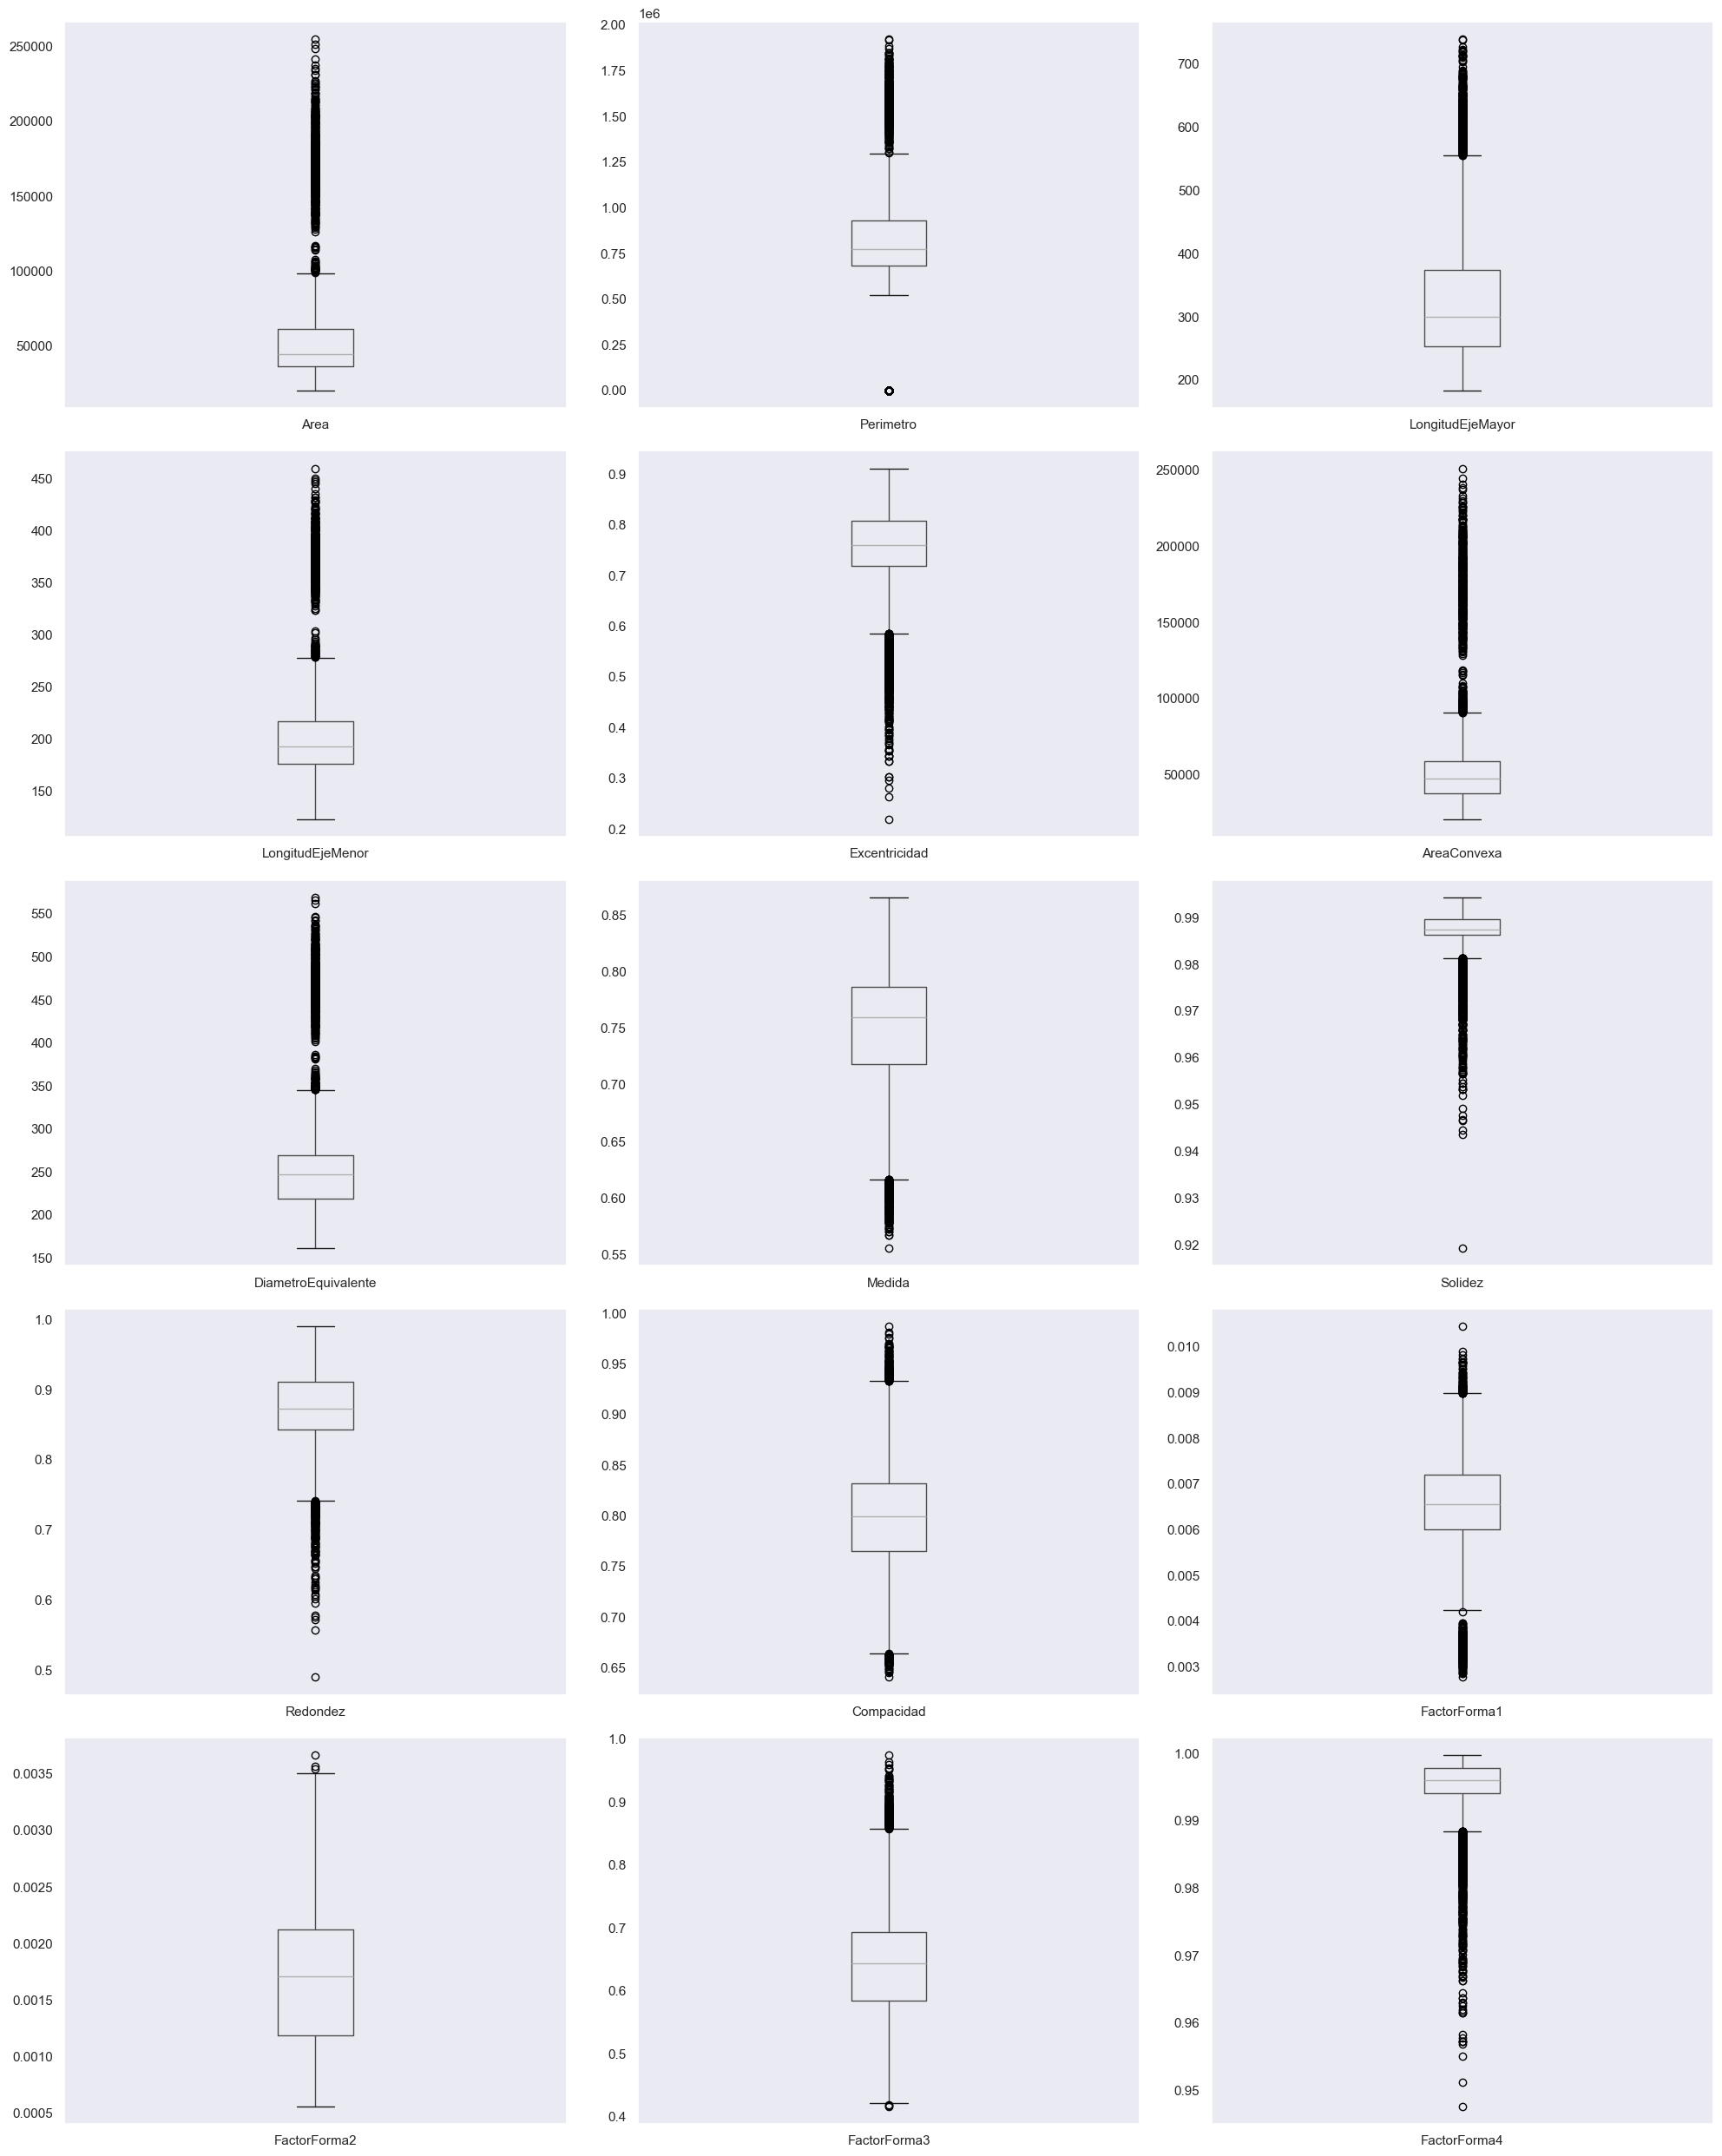

In [2014]:
num_cols = len(numeric_cols)

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 5 * 5))

for ax, col in zip(axes.flatten(), numeric_cols):
    df_clean.boxplot(column=[col], ax=ax, grid=False)

for i in range(num_cols, len(axes.flatten())):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

Como se puede ver, hay muchos outliers dentro de los datos. Por lo que se entra a revisar por casos. 
Para el caso del Perimetro y la Solidez se decide limpiar los datos muy cercanos a 0 puesto que están alejados de la distribución. 

In [2015]:
((df_clean['Perimetro'] < 0.1*1e6).sum()/len(df_clean))*100


median = df_clean['Perimetro'][df_clean['Perimetro'] >= 0].median() 

df_clean['Perimetro'] = df_clean['Perimetro'].apply(lambda x: median if x < 0.1*1e6 else x)

In [2016]:
((df_clean['Solidez'] < 0.93).sum()/len(df_clean))*100

median = df_clean['Solidez'][df_clean['Solidez'] >= 0].median() 

df_clean['Solidez'] = df_clean['Solidez'].apply(lambda x: median if x < 0.93 else x) 

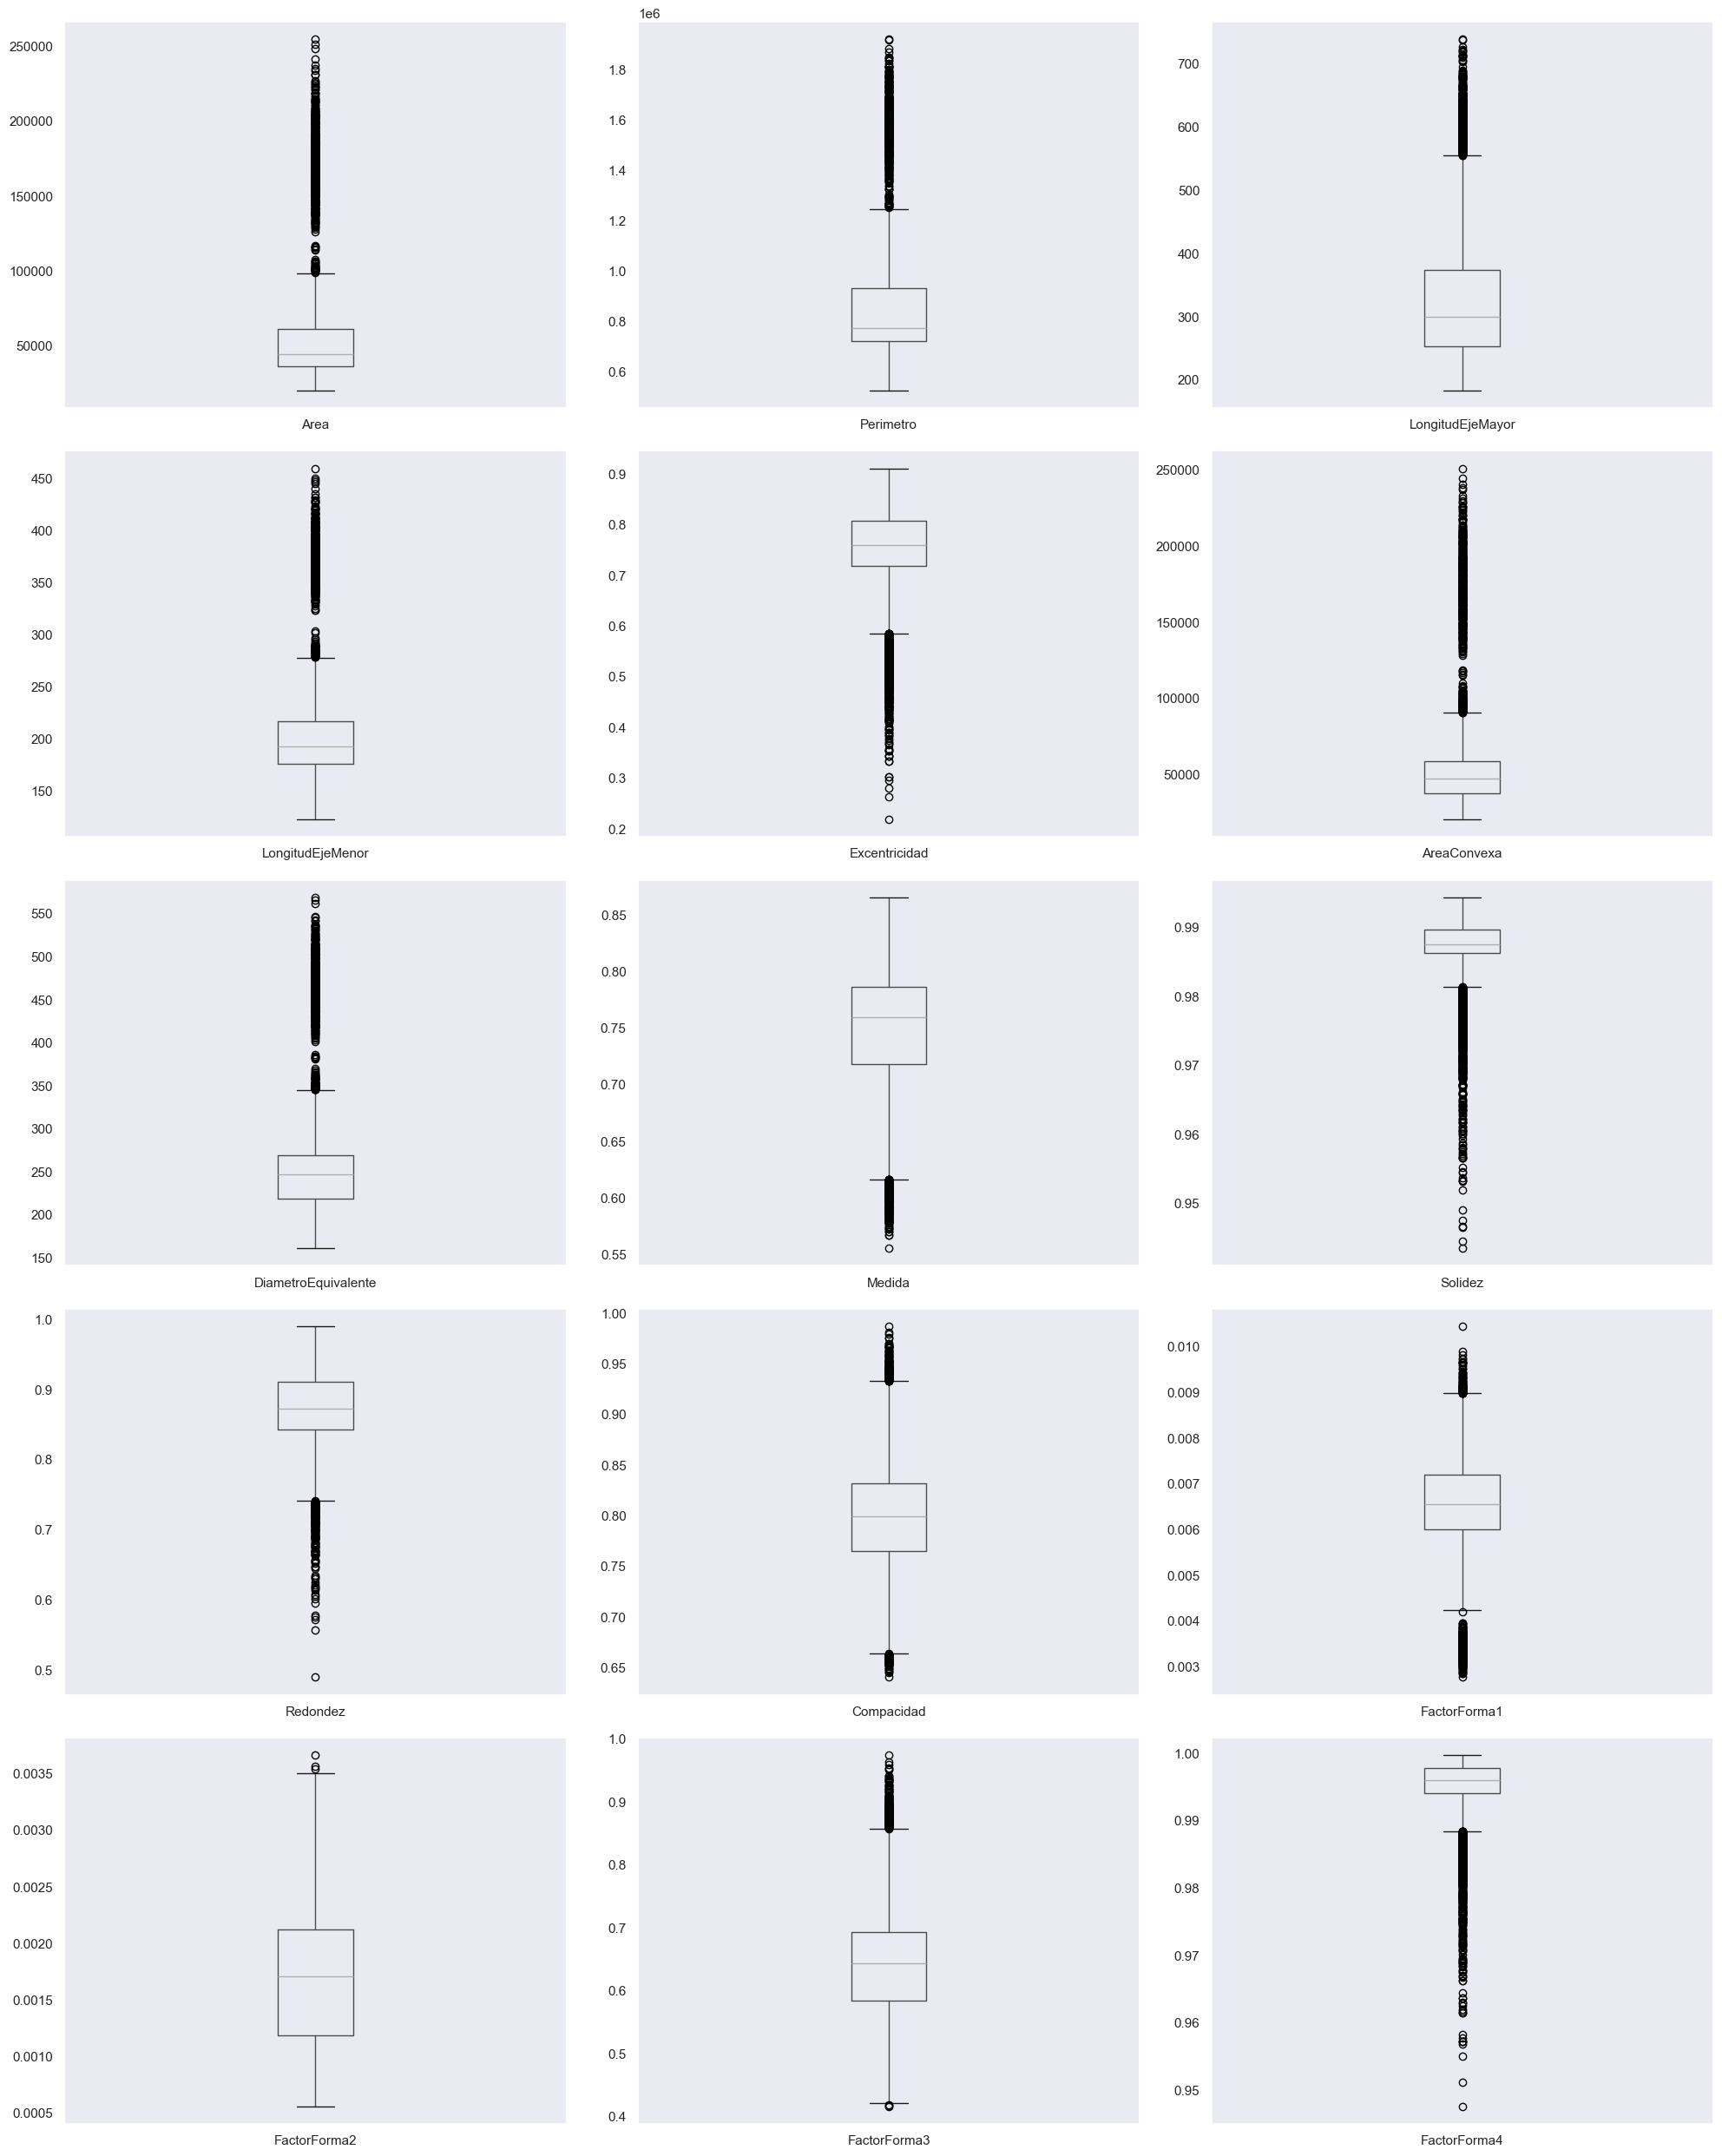

In [2017]:
num_cols = len(numeric_cols)

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 5 * 5))

for ax, col in zip(axes.flatten(), numeric_cols):
    df_clean.boxplot(column=[col], ax=ax, grid=False)

for i in range(num_cols, len(axes.flatten())):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

In [2018]:
cols = ['Area', 'Perimetro', 'LongitudEjeMayor', 'LongitudEjeMenor',
       'Excentricidad', 'AreaConvexa', 'DiametroEquivalente', 'Medida',
       'Solidez', 'Redondez', 'Compacidad', 'FactorForma1',
       'FactorForma3', 'FactorForma4']  

df_sin_outliers = df_clean.copy()

for col in cols:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    low = Q1 - 1.5 * IQR
    high = Q3 + 1.5 * IQR
    
    df_sin_outliers = df_sin_outliers[(df_sin_outliers[col] >= low) & (df_sin_outliers[col] <= high)]

print("Shape original:", df_clean.shape)
print("Shape sin outliers:", df_sin_outliers.shape)

#df_clean = df_sin_outliers


Shape original: (13762, 21)
Shape sin outliers: (10409, 21)


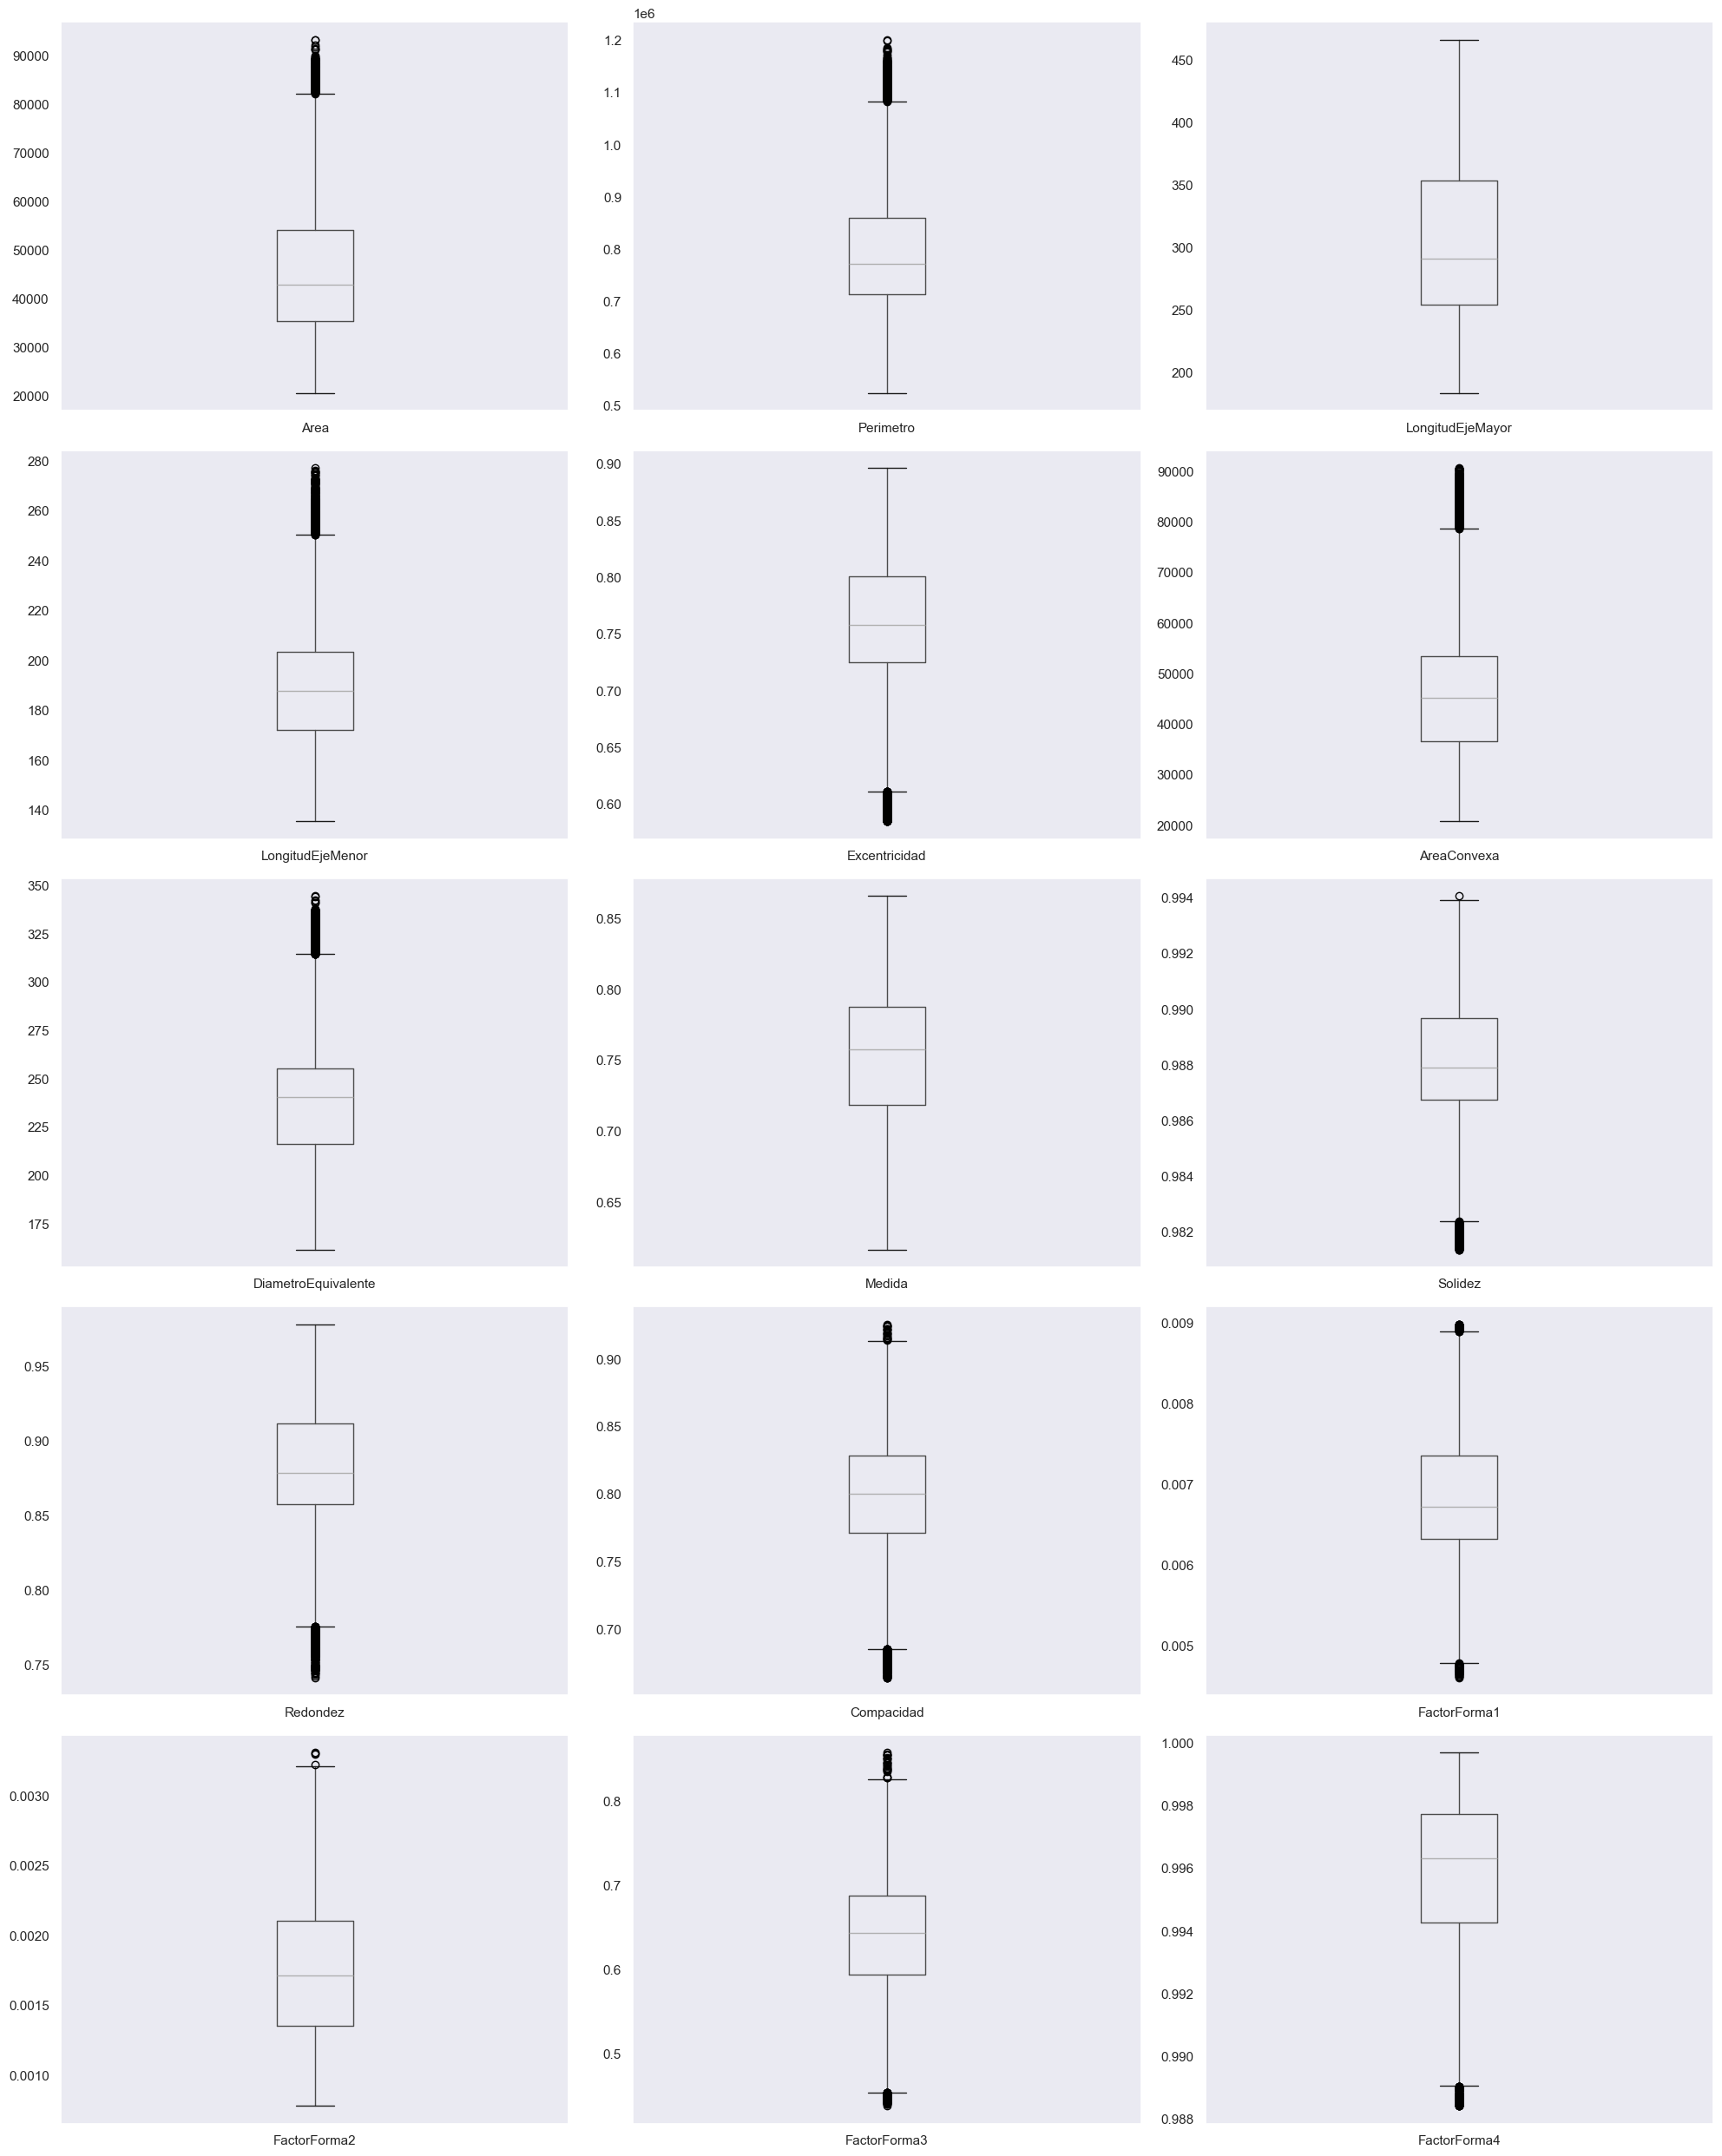

In [2019]:
num_cols = len(df_sin_outliers.columns)

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 5 * 5))

for ax, col in zip(axes.flatten(), numeric_cols):
    df_sin_outliers.boxplot(column=[col], ax=ax, grid=False)

for i in range(num_cols, len(axes.flatten())):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

Se realizó el ejercicio de eliminar outliers, pero al momento de experimentar con diferentes métodos se evaluó que esto hace que el desempeño empeore. Por lo que se presenta la gráfica de las distribuciones sin outliers, pero se utiliza el dataset con outliers para evitar eliminar información importante que introduzca sesgos al modelo. 

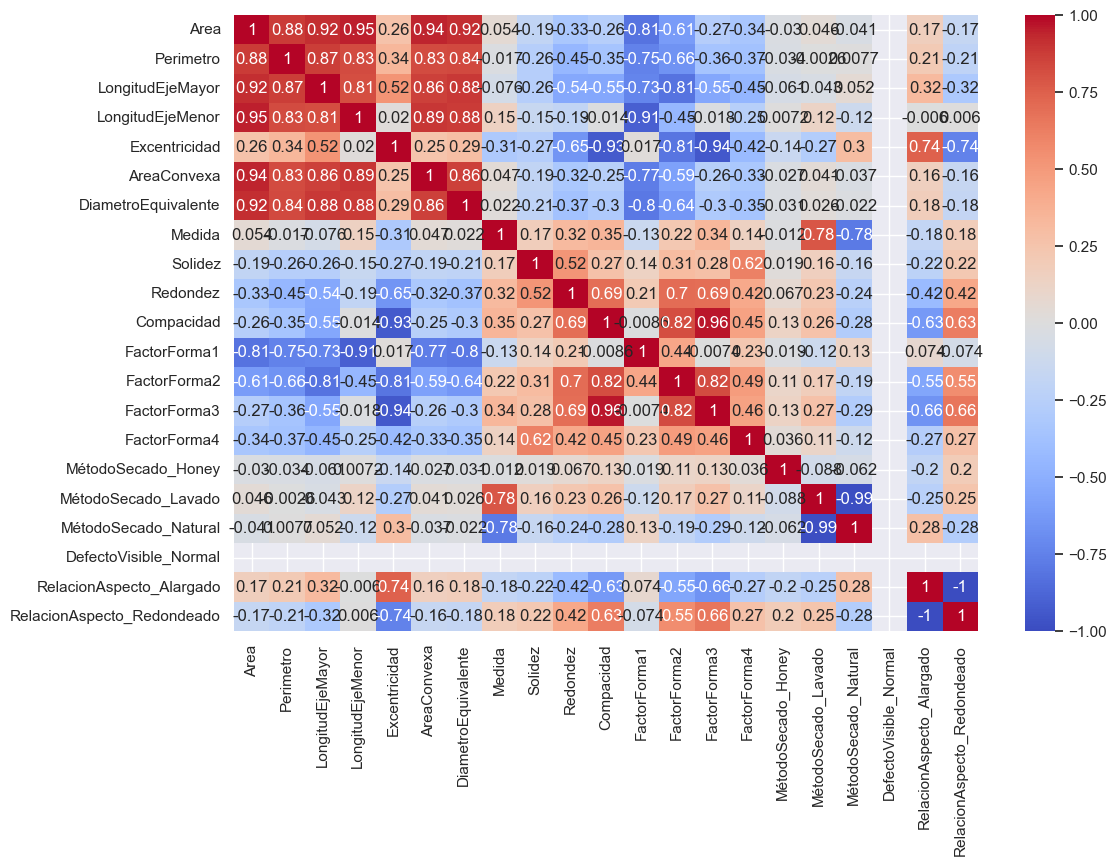

In [2020]:
corr_matrix = df_clean.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.show()

A partir de la correlación entre atributos, se decide la importancia de estos para selecciónar cuales se mantienen. En primer lugar, se ve que `DefectoVisible` solo tiene 1 valor, así que se puede ignorar este atributo pues es solo ruido. 

Siguiendo así, se puede ver que hay muchos atributos que estan fuertemente correlacionados, por lo que se pueden eliminar algunos. Para decidir cuales atributos eliminar se trató de evitar que se tuviera una correlación mayor a 0.8 y para decidir cuales eliminar, se empezó por las columnas con mayor cantidad de datos imputados. 

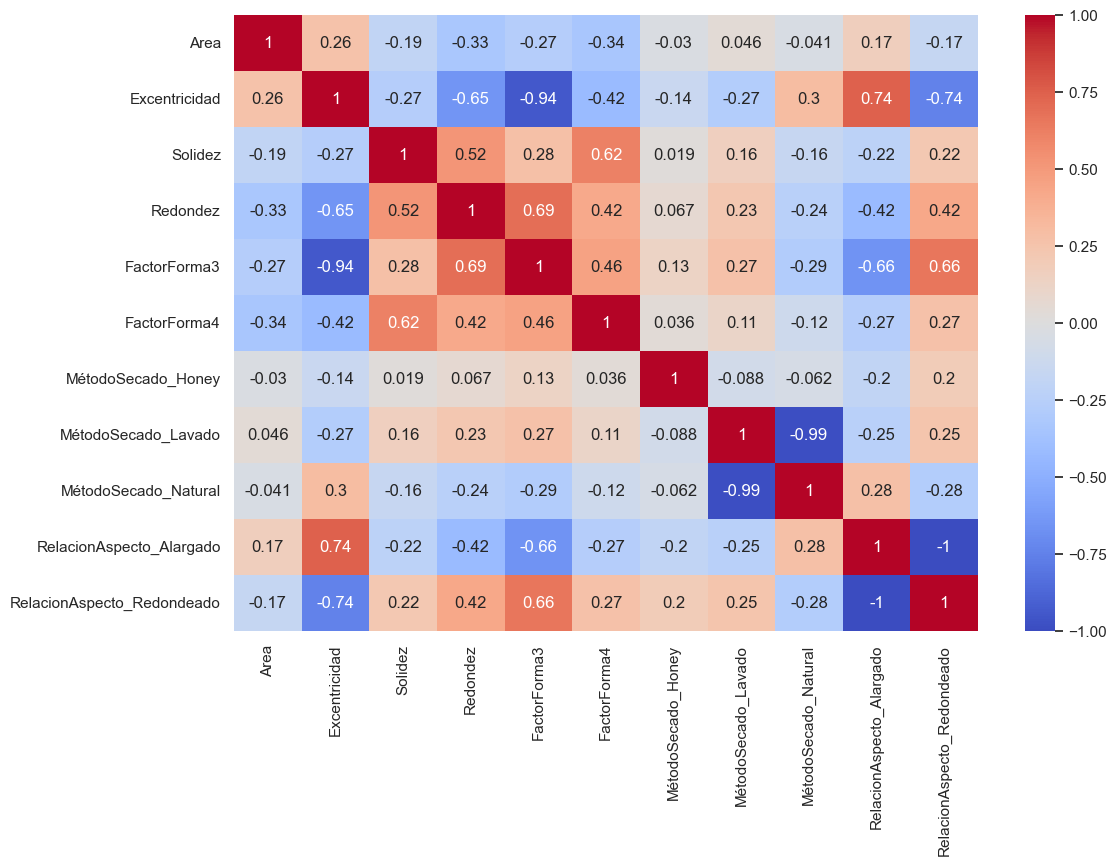

In [2021]:
#df_clean = df_clean.drop(columns=['DefectoVisible_Normal', 'LongitudEjeMayor'] , axis=1)
df_clean = df_clean.drop(columns=['DefectoVisible_Normal', 'Perimetro', 'AreaConvexa', 'DiametroEquivalente', 'LongitudEjeMenor', 'LongitudEjeMayor', 'Compacidad', 'Medida', 'FactorForma2', 'FactorForma1'], axis=1)
corr_matrix = df_clean.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.show()

Finalmente, se utilizó un MinMaxScaler para normalizar los datos debido a que estos tienen rangos muy diferentes entre columnas. 
Con esto, se realiza una gráfica para identificar grupos naturales. Como se puede ver ya es evidente que se forman ciertos grupos por lo que el procesamiento de datos preliminar muestra resultados adecuados. 

In [2022]:
mms= MinMaxScaler()
df_prep = mms.fit_transform(df_clean)
df_norm = pd.DataFrame(df_prep, columns =df_clean.columns)
df_clean = df_norm

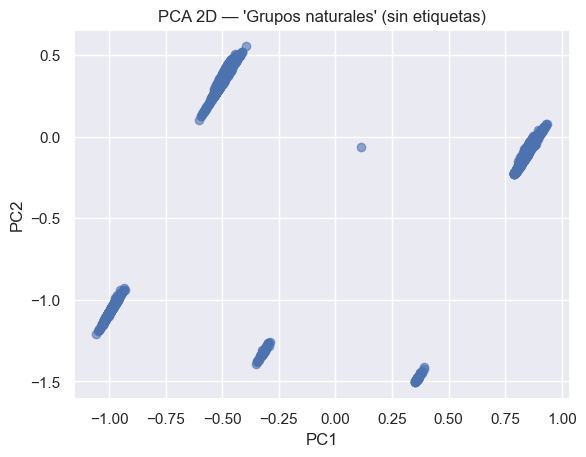

In [2023]:
Xt = df_clean
pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(Xt.toarray() if hasattr(Xt, "toarray") else Xt)

plt.figure()
plt.scatter(Z[:,0], Z[:,1], alpha=0.6)
plt.title("PCA 2D — 'Grupos naturales' (sin etiquetas)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

### Conclusiones Entendimiento y Preparación de datos:

- Se revisó el dataset el cual originalmente contenía 14291 registros y 19 columnas. De las cuales se detectaron 4 columnas categóricas. 
- Se revisó la calidad de los datos en donde se encontró que múltiples columnas tenían datos nulos. Estos se solucionaron con imputación de media para los numéricos e imputación de moda para los categóricos. Se analizó adicionalmente, que columnas se podían revisar para eliminar al tener porcentajes altos de datos nulos. 
- Siguiendo con unicidad, se eliminaron los duplicados. Se tomó esta decisión ya que representan un porcentaje muy bajo dentro del dataset. 
- Para consistencia, se ajustaron los valores de las columnas categóricas para que siguieran con las reglas impuestas en el diccionario. 
- Finalmente, en cuanto a validez se ajustaron las columnas numéricas para que solo tengan valores positivos y respeten los rangos establecidos por definición del problema. 
- Se analizaron las distribuciones de los datos después de limpiar los datos. Como hay muchos outliers se generó una limpieza con cuantiles. Sin embargo, se descartó ya que en la práctica esto elimina muchos datos significativos para el problema. 
- En cuanto a selección de variables, se utilizó la correlación con lo que se eliminaron diferentes variables para garantizar correlaciones menores a 0.8 y mayores a -0.8. 
- Se normalizaron los datos usando un MinMaxScaler y por último se generó una gráfica de grupos naturales con la que se revisó que se forman unos cuantos grupos. 

# KMeans

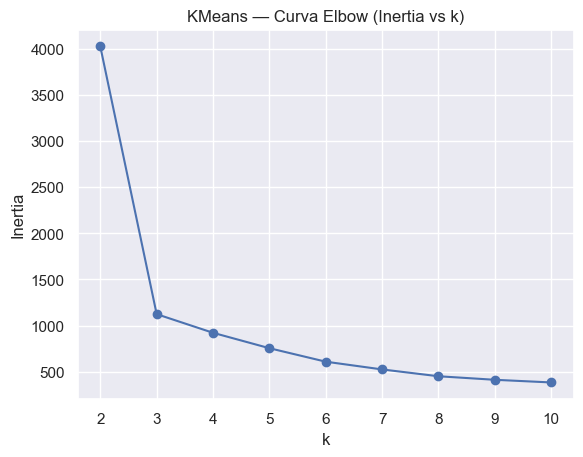

In [2024]:
# Curva elbow para KMeans
inertias = []
ks = list(range(2, 11))
for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(df_clean)
    inertias.append(km.inertia_)

plt.figure()
plt.plot(ks, inertias, marker="o")
plt.title("KMeans — Curva Elbow (Inertia vs k)")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.xticks(ks)
plt.show()

In [2025]:
def plot_distortion(data,
                    k_min=1, 
                    k_max=11,
                    ylabel = 'Distortion',
                    xlabel = 'Number of clusters',
                    title = 'Distortion Plot'):

    distortions = []
    for i in range(k_min, k_max):
        km = KMeans(n_clusters=i,
                 init='k-means++',
                 n_init=10,
                 max_iter=300,
                 random_state=0)
        km.fit(data)
        distortions.append(km.inertia_)
    plt.plot(range(k_min,k_max), distortions, marker='o')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

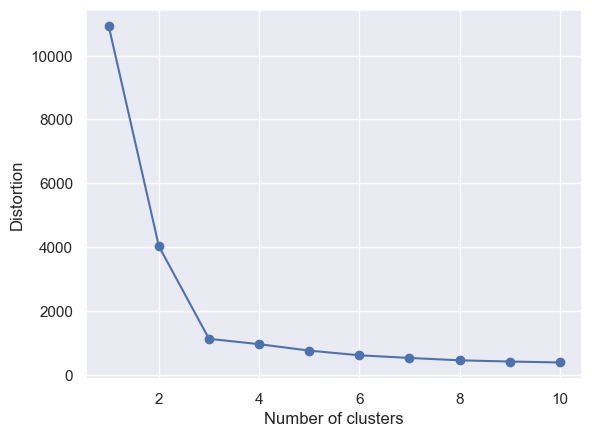

In [2026]:
plot_distortion(df_clean,1,11)

In [2027]:
def plot_silhouette(data, 
                    labels,
                   ylabel = 'Grupos',
                   xlabel = "Coeficiente de silueta",
                   title = 'Gráfica de silueta'):
    cluster_labels = np.unique(labels)
    print(cluster_labels)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(data,
                                        labels,
                                        metric='euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[labels == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper),
                        c_silhouette_vals,
                        height=1.0,
                        edgecolor='none',
                        color=color)
        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)
    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg,
                color="red",
                linestyle="--")
    plt.yticks(yticks, cluster_labels+1)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.show()

A partir de la Curva del Codo de inercia y distorsión se puede determinar la cantidad de clusters que se deben realizar. Ambas gráficas indican que alrededor entre 3 y 4 clusters es un número adecuado. Por esta razón, se construye el modelo con estas opciones y se analiza cual es la mejor. 

### KMeans con 3 clusters

In [2035]:
kmeans = KMeans(n_clusters=6, random_state=0) 

res_kmeans = kmeans.fit(df_clean)

centroides3 = kmeans.cluster_centers_

<Axes: xlabel='Cluster'>

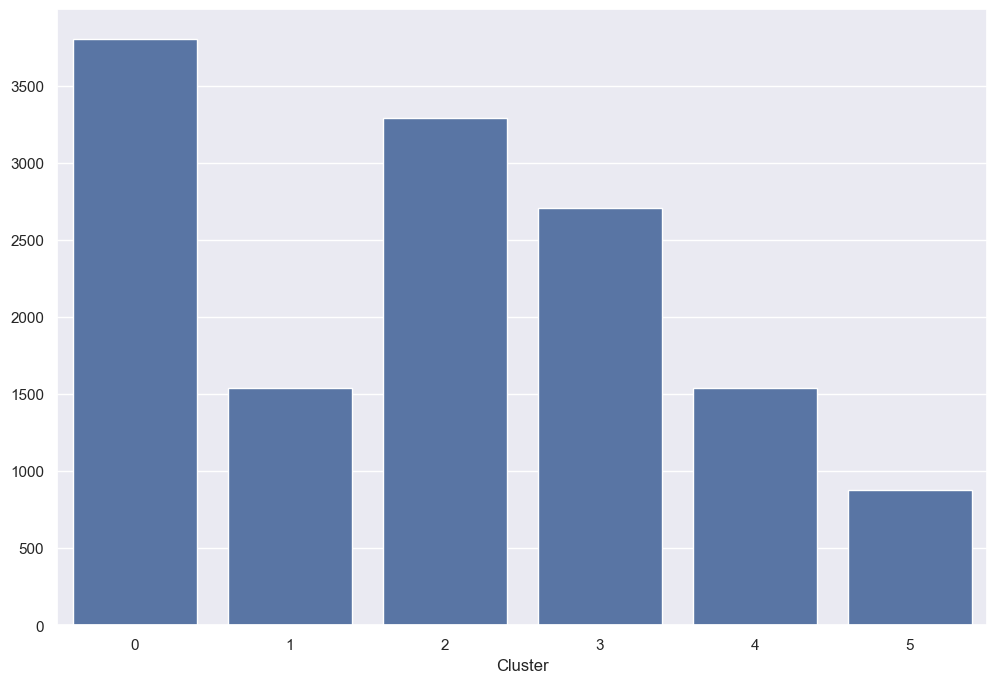

In [2036]:
labels = res_kmeans.labels_
df_clean['Cluster'] = labels
cluster_distrib = df_clean['Cluster'].value_counts()
fig=plt.figure(figsize=(12,8))
sns.barplot(x=cluster_distrib.index, y=cluster_distrib.values, color='b')

Dentro de esta gráfica se puede ver la distribución de datos por cada cluster. Se puede ver de entrada que el cluster 2 es el que tiene menos datos asociados. 

In [2037]:
etiquetas = kmeans.fit_predict(df_clean)
sil_score = silhouette_score(df_clean, etiquetas)
sample_silhouette_values = silhouette_samples(df_clean, etiquetas)

print("Silueta: ", sil_score)

Silueta:  0.8354373495443164


Se calcula la silueta del problema con el fin de poder comparar más adelante las diferentes iteraciones. 

[0 1 2 3 4 5]


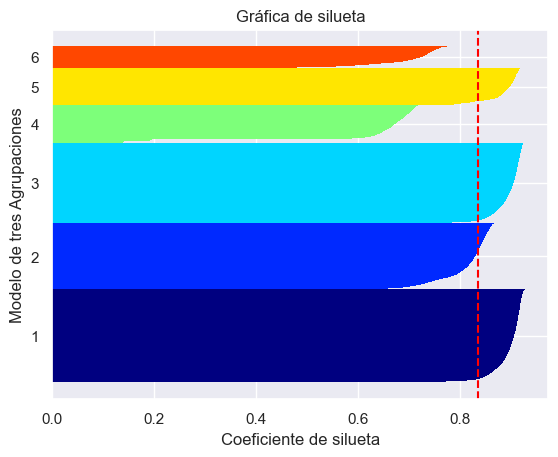

In [2038]:
plot_silhouette(data = df_clean, 
                labels = kmeans.labels_, 
                ylabel = 'Modelo de tres Agrupaciones')

Se genera una gráfica respecto al coeficiente de silueta 

In [1978]:
print(df_clean.shape)
print(len(centroides3[0]))

(13762, 11)
10


c:\Users\laura\anaconda3\envs\BI\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


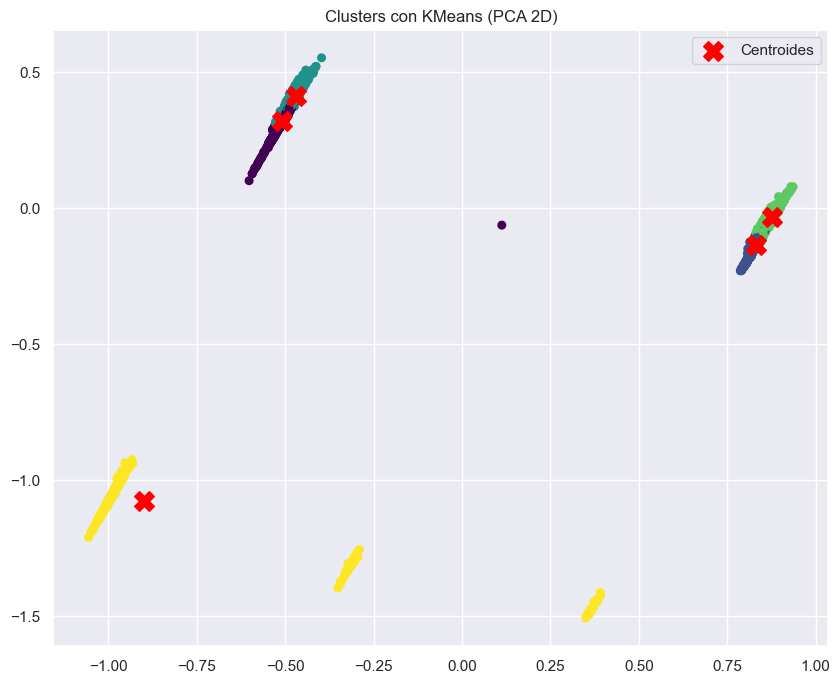

In [2032]:
# Separamos solo las features originales
X_features = df_clean.drop(columns=['Cluster'])

# PCA solo con las features
pca = PCA(n_components=2)
Xc = pca.fit_transform(X_features)

# Proyectamos los centroides (también en el espacio original, sin 'Cluster')
centroides_proj = pca.transform(centroides3)

# Gráfico clusters + centroides proyectados
plt.figure(figsize=(10,8))
plt.scatter(Xc[:, 0], Xc[:, 1], c= kmeans.labels_, s=30, cmap='viridis')

plt.scatter(centroides_proj[:, 0], centroides_proj[:, 1],
            c='red', marker='X', s=200, label='Centroides')

plt.legend()
plt.title("Clusters con KMeans (PCA 2D)")
plt.show()


In [1980]:
df_clean = df_clean.drop(columns=['Cluster'])

### KMeans con 4 Clusters

<Axes: xlabel='Cluster'>

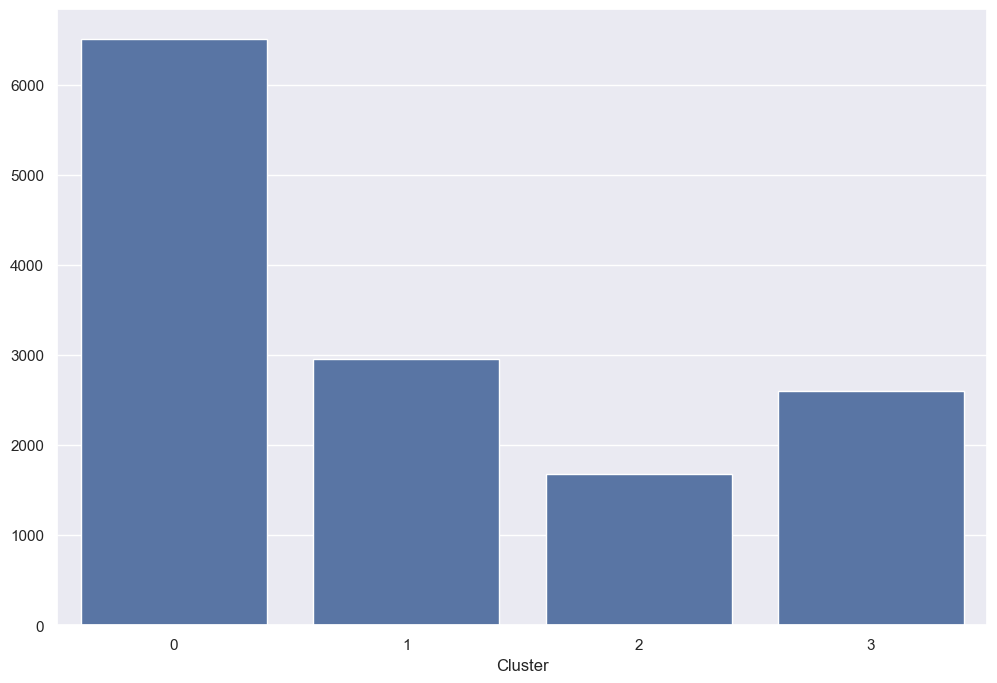

In [1981]:
kmeans4 = KMeans(n_clusters=4, random_state=0) 

res_kmeans4 = kmeans4.fit(df_clean)

centroides4 = kmeans4.cluster_centers_

labels4 = res_kmeans4.labels_
df_clean['Cluster'] = labels4
cluster_distrib4 = df_clean['Cluster'].value_counts()
fig=plt.figure(figsize=(12,8))
sns.barplot(x=cluster_distrib4.index, y=cluster_distrib4.values, color='b')

In [1982]:
etiquetas = kmeans4.fit_predict(df_clean)
sil_score = silhouette_score(df_clean, etiquetas)
sample_silhouette_values = silhouette_samples(df_clean, etiquetas)

print("Silueta: ", sil_score)
print(len(sample_silhouette_values))

Silueta:  0.8367096390763507
13762


[0 1 2 3]


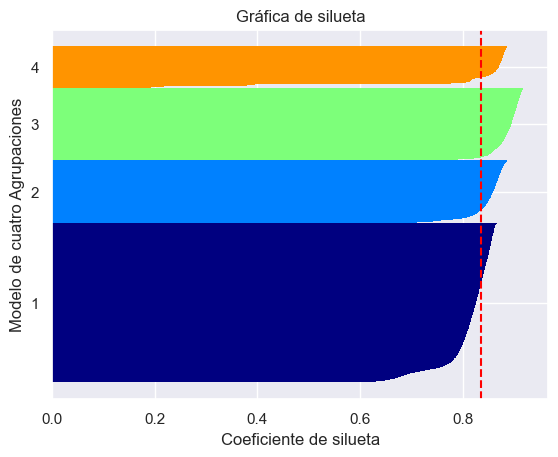

In [1983]:
plot_silhouette(data = df_clean, 
                labels = kmeans4.labels_, 
                ylabel = 'Modelo de cuatro Agrupaciones')

In [1984]:
#sns.pairplot(data=df_clean, hue="Cluster", palette="Dark2")

c:\Users\laura\anaconda3\envs\BI\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


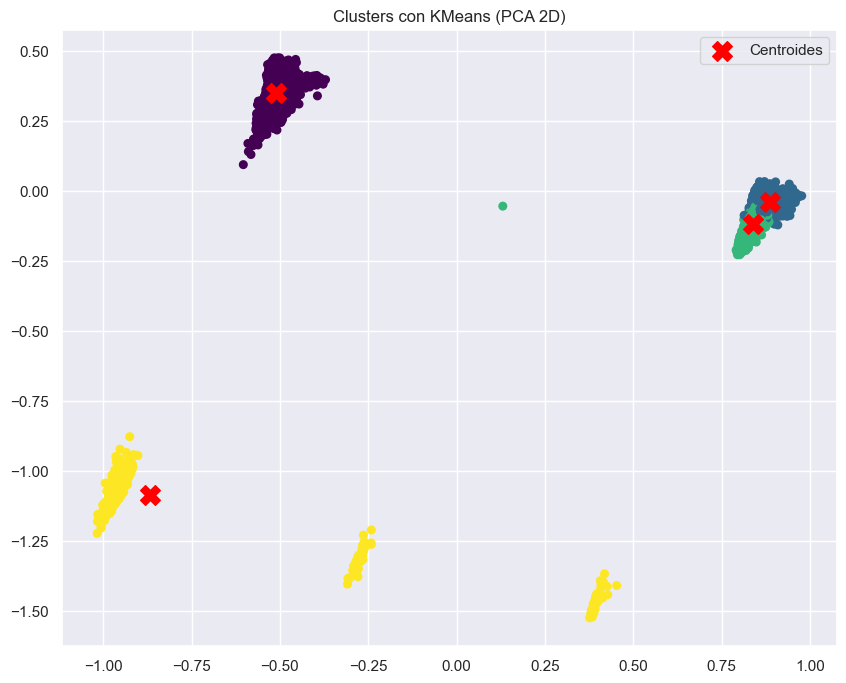

In [1985]:
X_features = df_clean.drop(columns=['Cluster'])
# PCA solo con las features
pca = PCA(n_components=2)
Xc = pca.fit_transform(X_features)

centroides_proj = pca.transform(centroides4)

plt.figure(figsize=(10,8))
plt.scatter(Xc[:, 0], Xc[:, 1], c=kmeans4.labels_, s=30, cmap='viridis')

plt.scatter(centroides_proj[:, 0], centroides_proj[:, 1],
            c='red', marker='X', s=200, label='Centroides')

plt.legend()
plt.title("Clusters con KMeans (PCA 2D)")
plt.show()


In [1986]:
df_clean = df_clean.drop(columns=['Cluster'])

Los resultados prevíos permiten ver que hay un mejor ajuste de los datos cuando se utilizan 3 clusters. Esto se ve representando el el coeficiente de silueta el cuál alcanza un valor de 0.66 cuando se utilizan 3 clusters.
A partir de las visualizaciones realizadas para los resultados con el uso de 3 clusters, se puede ver que los datos se distribuyen principalmente